In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.pyplot import rcParams
import warnings
warnings.filterwarnings('ignore')

import re
import jax.numpy as jnp
from jax import grad, jit, partial
import ticktack
from tinygp import kernels, GaussianProcess
from ticktack import fitting_tinygp as fitting
from astropy.table import Table
from tqdm import tqdm
import scipy
import jax

rcParams['figure.figsize'] = (10.0, 5.0)

In [2]:
cbm = ticktack.load_presaved_model('Guttler14', production_rate_units = 'atoms/cm^2/s')
cf = fitting.CarbonFitter(cbm)
cf.load_data('400_BCE_Data_processed.csv', time_oversample=50)
cf.prepare_function(use_control_points=True, interp="gp")

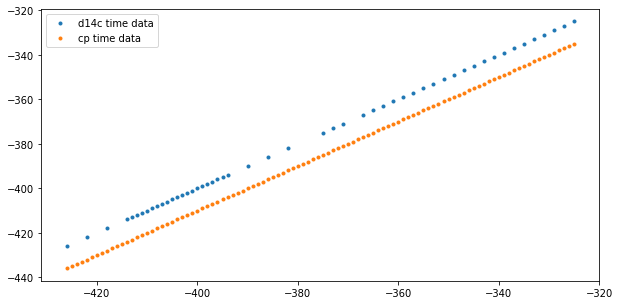

In [3]:
plt.plot(cf.time_data, cf.time_data, ".", label="d14c time data")
plt.plot(cf.control_points_time, cf.control_points_time -10, ".", label="cp time data")
plt.legend()

In [4]:
steady_state = cf.steady_state_production * jnp.ones((len(cf.control_points_time)+1,))
params = steady_state
bounds = tuple([(0, None)] * len(params))

In [5]:
cf.gp_neg_log_likelihood(params)

DeviceArray(59.34910174, dtype=float64)

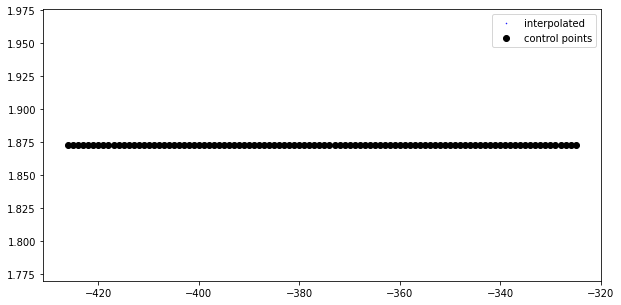

In [6]:
out = cf.production(cf.time_grid_fine, params)
plt.plot(cf.time_grid_fine, out, ".b", markersize=1, label="interpolated")
plt.plot(cf.control_points_time, params[:-1], "ok", label='control points')
plt.legend()
# plt.xlim(-440, -420)

In [7]:
print("total likelihood: ", cf.gp_likelihood(params))
print("gp likelihood: ", cf.gp_neg_log_likelihood(params))
print("chi2: ", cf.loss_chi2(params))

total likelihood:  774.2863320586426
gp likelihood:  59.34910173884309
chi2:  714.9372303197996


In [8]:
%%time
cf.gp_likelihood(params)

CPU times: user 469 ms, sys: 1.06 s, total: 1.53 s
Wall time: 149 ms


DeviceArray(774.28633206, dtype=float64)

In [9]:
%%time
soln = scipy.optimize.minimize(cf.gp_likelihood, params, bounds=bounds, tol=2.220446049250313e-09)

CPU times: user 1h 29min 36s, sys: 3h 22min 7s, total: 4h 51min 43s
Wall time: 30min 59s


In [10]:
soln.x

array([1.6544328 , 1.90452021, 2.02977887, 1.99072169, 1.82493273,
       1.61591751, 1.48993472, 1.470403  , 1.52646415, 1.61680469,
       1.69502108, 1.807466  , 2.03711738, 2.26791059, 2.23266949,
       2.05979814, 2.09392307, 2.17064044, 1.98973673, 1.91675929,
       2.2641053 , 2.39127884, 2.10741525, 1.88661205, 1.90116188,
       1.87844174, 1.87194416, 1.93044831, 2.13083373, 2.41960777,
       2.26026764, 1.97124401, 2.0972239 , 2.35833611, 2.46362548,
       2.41907182, 2.24627259, 2.02711906, 1.9076207 , 1.90912451,
       1.98666302, 2.08556198, 2.13841073, 2.13013591, 2.07467497,
       2.00286285, 1.95621838, 1.93731388, 1.9328552 , 1.94929622,
       2.01912518, 2.17674413, 2.35208921, 2.4086832 , 2.37435805,
       2.36878007, 2.39915424, 2.39977033, 2.30949079, 2.09497775,
       1.91648161, 2.04587247, 2.36567808, 2.52043957, 2.47333743,
       2.36461715, 2.22235458, 2.02314915, 1.83516595, 1.79931475,
       1.91979754, 2.1183396 , 2.33886932, 2.51699745, 2.59543

In [11]:
cf.gp_likelihood(soln.x)

DeviceArray(66.92943228, dtype=float64)

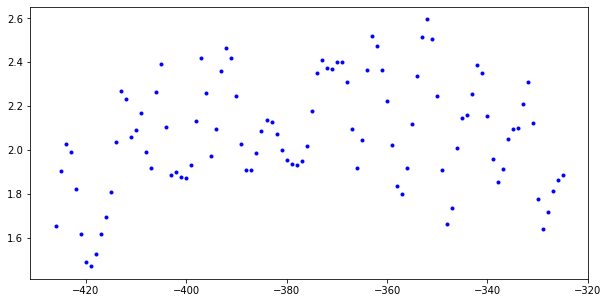

In [12]:
plt.plot(cf.control_points_time, soln.x[:-1], ".b")

In [13]:
soln.message

'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'

In [14]:
cf.gp_likelihood(params=soln.x)

DeviceArray(66.92943228, dtype=float64)

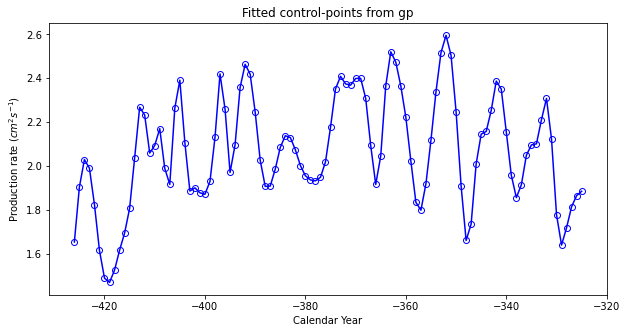

In [15]:
plt.plot(cf.control_points_time, soln.x[:-1], "ob", fillstyle="none")
plt.plot(cf.control_points_time, soln.x[:-1], "b")
plt.ylabel("Production rate ($cm^2s^{-1}$)");
plt.xlabel("Calendar Year");
plt.title(r"Fitted control-points from gp");

In [16]:
fine = cf.dc14_fine(params=soln.x)
coarse = cf.dc14(params=soln.x)

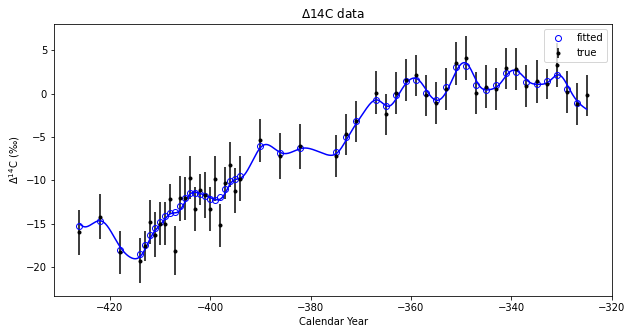

In [17]:
plt.plot(cf.time_grid_fine, fine, "b")
plt.plot(cf.time_data[:-1], coarse, "ob", fillstyle="none", label="fitted")
plt.errorbar(cf.time_data, cf.d14c_data, yerr=cf.d14c_data_error, fmt=".k", label="true")
plt.legend()
plt.ylabel("$\Delta^{14}$C (‰)")
plt.xlabel("Calendar Year");
plt.title("$\Delta$14C data");

In [18]:
print("total likelihood: ", cf.gp_likelihood(soln.x))
print("gp likelihood: ", cf.gp_neg_log_likelihood(soln.x))
print("chi2: ", cf.loss_chi2(soln.x))

total likelihood:  66.92943227818765
gp likelihood:  61.6494327872919
chi2:  5.279999490895751


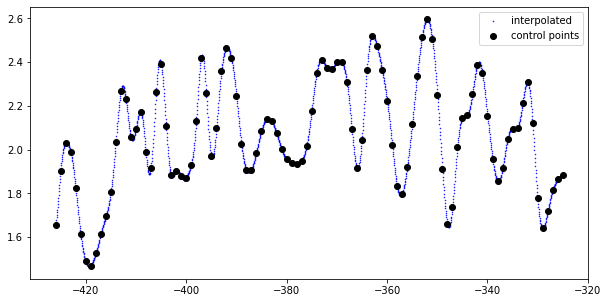

In [19]:
out = cf.production(cf.time_grid_fine, soln.x)
plt.plot(cf.time_grid_fine, out, ".b", markersize=1, label="interpolated")
plt.plot(cf.control_points_time, soln.x[:-1], "ok", label='control points')
plt.legend()

In [26]:
matern32 = np.array([1.64020496, 1.89753848, 2.01179489, 1.9785422 , 1.81363453,
       1.59947136, 1.48841209, 1.48488675, 1.55470805, 1.66057913,
       1.72097105, 1.78765711, 1.98009502, 2.24229633, 2.25534079,
       2.07390008, 2.09996162, 2.1624614 , 2.02154143, 1.89533406,
       2.29156256, 2.36281857, 2.10976963, 1.88188099, 1.92629082,
       1.86123407, 1.87932658, 1.97239226, 2.09059458, 2.42509554,
       2.24717411, 1.98034002, 2.15429256, 2.3680923 , 2.42892708,
       2.38856132, 2.24038707, 2.03315887, 1.93415563, 1.93665946,
       2.00306035, 2.09327783, 2.13070118, 2.12015296, 2.07284067,
       2.00072921, 1.96674321, 1.95691131, 1.95263047, 1.95951212,
       2.01101407, 2.15562078, 2.34533774, 2.41804187, 2.38966125,
       2.36644911, 2.36723508, 2.35487908, 2.30677972, 2.14512009,
       1.95696441, 2.0656364 , 2.36750192, 2.50107729, 2.468006  ,
       2.37943663, 2.23309733, 2.03400008, 1.83934691, 1.80763014,
       1.92377285, 2.11707142, 2.34033932, 2.50999497, 2.58184438,
       2.48033809, 2.23594208, 1.93972687, 1.69049792, 1.74216108,
       2.004313  , 2.13613745, 2.16634975, 2.27589915, 2.39505255,
       2.33938229, 2.1470738 , 1.97639435, 1.86876382, 1.90723507,
       2.04399432, 2.1059226 , 2.11458501, 2.20612467, 2.29357451,
       2.1206685 , 1.78798917, 1.668846  , 1.728371  , 1.79633104,
       1.85317522, 1.88585494, 1.89204024])
linear = np.array([1.89363959, 1.77072593, 1.75264088, 1.56139717, 1.91315407,
       2.18186108, 2.12273598, 2.15139975, 1.8747374 , 1.9919975 ,
       2.26624611, 2.32133033, 2.21331508, 2.00514102, 1.95528112,
       2.08758559, 2.40094881, 2.2423129 , 2.35118368, 2.01433349,
       2.17496925, 2.39776699, 1.84525825, 2.23184444, 2.06272956,
       2.06850577, 2.00214273, 1.77290152])
linear_time = np.array([-427., -426., -422., -418., -414., -411., -408., -405.,
             -402., -399., -396., -393., -390., -386., -382., -375.,
             -371., -367., -363., -359., -355., -351., -347., -343.,
             -339., -335., -331., -327.])

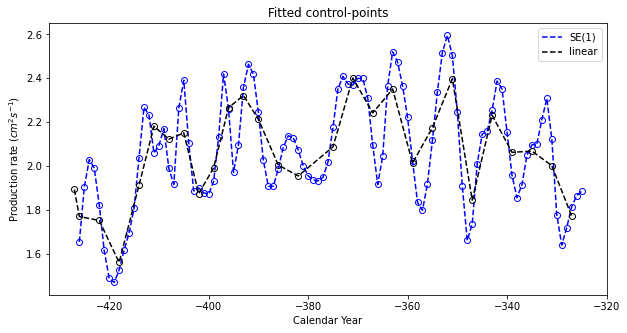

In [36]:
plt.plot(cf.control_points_time, soln.x[:-1], "ob", fillstyle="none")
plt.plot(cf.control_points_time, soln.x[:-1], "--b", label="SE(1)")
# plt.plot(cf.control_points_time, matern32[:-1], "or", fillstyle="none")
# plt.plot(cf.control_points_time, matern32[:-1], "--r", label="Matern32")
plt.plot(linear_time, linear, "ok", fillstyle="none")
plt.plot(linear_time, linear, "--k", label="linear")
plt.ylabel("Production rate ($cm^2s^{-1}$)");
plt.xlabel("Calendar Year");
plt.title(r"Fitted control-points");
plt.legend()